# **2. 모델링 과정**



> **2.1. 모델링용 데이터 가져오기**




In [ ]:
# train 
import pandas as pd

train = pd.read_csv('train_small.csv')
print('Training data 구조: ', train.shape)
train.head()

Training data 구조:  (307511, 92)


,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_CREDIT_ENDDATE_bureau_max,DAYS_CREDIT_bureau_max,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_ENDDATE_FACT_bureau_max,AMT_CREDIT_SUM_bureau_min,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,AMT_CREDIT_SUM_DEBT_bureau_mean,AMT_CREDIT_MAX_OVERDUE_bureau_mean,DAYS_CREDIT_ENDDATE_bureau_mean,AMT_INCOME_TOTAL,AMT_CREDIT_SUM_bureau_mean,DAYS_CREDIT_bureau_mean,AMT_CREDIT_SUM_bureau_max,DAYS_ENDDATE_FACT_bureau_mean,DAYS_CREDIT_bureau_min,DAYS_CREDIT_UPDATE_bureau_max,DAYS_ENDDATE_FACT_bureau_min,DAYS_CREDIT_ENDDATE_bureau_sum,CODE_GENDER_F,AMT_CREDIT_SUM_bureau_sum,DAYS_CREDIT_UPDATE_bureau_sum,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT_UPDATE_bureau_min,NAME_EDUCATION_TYPE_Higher education,AMT_CREDIT_SUM_LIMIT_bureau_mean,HOUR_APPR_PROCESS_START,AMT_CREDIT_SUM_DEBT_bureau_max,DAYS_CREDIT_ENDDATE_bureau_min,AMT_CREDIT_MAX_OVERDUE_bureau_max,YEARS_BEGINEXPLUATATION_MEDI,...,CREDIT_TYPE_Credit card_bureau_mean,DEF_30_CNT_SOCIAL_CIRCLE,CREDIT_TYPE_Consumer credit_bureau_mean,AMT_ANNUITY_bureau_sum,REGION_RATING_CLIENT_W_CITY,AMT_CREDIT_SUM_DEBT_bureau_min,AMT_CREDIT_SUM_LIMIT_bureau_max,AMT_REQ_CREDIT_BUREAU_QRT,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_TYPE_Microloan_bureau_mean,CREDIT_TYPE_Mortgage_bureau_mean,FLOORSMAX_AVG,AMT_CREDIT_SUM_DEBT_bureau_count,FLAG_DOCUMENT_3,YEARS_BEGINEXPLUATATION_AVG,AMT_CREDIT_SUM_LIMIT_bureau_sum,OCCUPATION_TYPE_Core staff,CREDIT_ACTIVE_Active_bureau_mean,CREDIT_ACTIVE_Closed_bureau_mean,AMT_ANNUITY_bureau_count,AMT_REQ_CREDIT_BUREAU_MON,DEF_60_CNT_SOCIAL_CIRCLE,NAME_INCOME_TYPE_Working,CODE_GENDER_M,FLAG_WORK_PHONE,FLAG_DOCUMENT_16,CREDIT_TYPE_Consumer credit_bureau_sum,OBS_60_CNT_SOCIAL_CIRCLE,CREDIT_ACTIVE_Closed_bureau_sum,AMT_CREDIT_MAX_OVERDUE_bureau_min,FLAG_DOCUMENT_18,CREDIT_TYPE_Credit card_bureau_sum,AMT_CREDIT_SUM_OVERDUE_bureau_max,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,DAYS_CREDIT_ENDDATE_bureau_count,DAYS_ENDDATE_FACT_bureau_count,TARGET,SK_ID_CURR
0,0.139376,0.262949,-9461,24700.5,406597.5,351000.0,-637,780.0,-103.0,-2120,-3648.0,-36.0,0.0,-1134.0,0.018801,0.0149,49156.2,1681.029,-349.0,202500.0,108131.945625,-874.00,450000.0,-697.500000,-1437.0,-7.0,-1185.0,-2094.0,0,865055.565,-3999.0,1.0,-1185.0,0,7997.14125,10,245781.0,-1072.0,5043.645,0.9722,...,0.5,2.0,0.5,0.0,2,0.0,31988.565,0.0,1,0.0,0.0,0.0833,5.0,1,0.9722,31988.565,0,0.25,0.75,7.0,0.0,2.0,1,1,0,0,4.0,2.0,6.0,0.0,0,4.0,0.0,0,0,1,6.0,6.0,1,100002
1,NaN,0.622246,-16765,35698.5,1293502.5,1129500.0,-1188,1216.0,-606.0,-291,-1186.0,-540.0,22248.0,-828.0,0.003541,0.0714,0.0,0.000,-544.5,270000.0,254350.125000,-1400.75,810000.0,-1097.333333,-2586.0,-43.0,-2131.0,-2178.0,1,1017400.500,-3264.0,0.0,-2131.0,1,202500.00000,11,0.0,-2434.0,0.000,0.9851,...,0.5,0.0,0.5,0.0,1,0.0,810000.000,0.0,0,0.0,0.0,0.2917,4.0,1,0.9851,810000.000,1,0.25,0.75,0.0,0.0,0.0,0,0,0,0,2.0,1.0,3.0,0.0,0,2.0,0.0,0,0,0,4.0,3.0,0,100003
2,0.729567,0.555912,-19046,6750.0,135000.0,135000.0,-225,-382.0,-408.0,-2531,-4260.0,-382.0,94500.0,-815.0,0.010032,NaN,0.0,0.000,-488.5,67500.0,94518.900000,-867.00,94537.8,-532.500000,-1326.0,-382.0,-683.0,-977.0,0,189037.800,-1064.0,0.0,-682.0,0,0.00000,9,0.0,-595.0,0.000,NaN,...,0.0,0.0,1.0,0.0,2,0.0,0.000,0.0,1,0.0,0.0,NaN,2.0,0,NaN,0.000,0,0.00,1.00,0.0,0.0,0.0,1,1,1,0,2.0,0.0,2.0,0.0,0,0.0,0.0,0,0,1,2.0,2.0,0,100004
3,NaN,0.650442,-19005,29686.5,312682.5,297000.0,-3039,NaN,NaN,-2437,-9833.0,NaN,NaN,-617.0,0.008019,NaN,NaN,NaN,NaN,135000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,0,NaN,17,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,2,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,1,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,1,0,0,0,NaN,2.0,NaN,NaN,0,NaN,NaN,0,0,1,NaN,NaN,0,100006
4,NaN,0.322738,-19932,21865.5,513000.0,513000.0,-3038,-783.0,-1149.0,-3458,-4311.0,-783.0,146250.0,-1106.0,0.028663,NaN,0.0,0.000,-783.0,121500.0,146250.000000,-1149.00,146250.0,-783.000000,-1149.0,-783.0,-783.0,-783.0,0,146250

In [ ]:
test = pd.read_csv('test_small.csv')
print('Testing data 구조: ', test.shape)
test.head()

Testing data 구조:  (48744, 91)


,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_CREDIT_ENDDATE_bureau_max,DAYS_CREDIT_bureau_max,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_ENDDATE_FACT_bureau_max,AMT_CREDIT_SUM_bureau_min,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,AMT_CREDIT_SUM_DEBT_bureau_mean,AMT_CREDIT_MAX_OVERDUE_bureau_mean,DAYS_CREDIT_ENDDATE_bureau_mean,AMT_INCOME_TOTAL,AMT_CREDIT_SUM_bureau_mean,DAYS_CREDIT_bureau_mean,AMT_CREDIT_SUM_bureau_max,DAYS_ENDDATE_FACT_bureau_mean,DAYS_CREDIT_bureau_min,DAYS_CREDIT_UPDATE_bureau_max,DAYS_ENDDATE_FACT_bureau_min,DAYS_CREDIT_ENDDATE_bureau_sum,CODE_GENDER_F,AMT_CREDIT_SUM_bureau_sum,DAYS_CREDIT_UPDATE_bureau_sum,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT_UPDATE_bureau_min,NAME_EDUCATION_TYPE_Higher education,AMT_CREDIT_SUM_LIMIT_bureau_mean,HOUR_APPR_PROCESS_START,AMT_CREDIT_SUM_DEBT_bureau_max,DAYS_CREDIT_ENDDATE_bureau_min,AMT_CREDIT_MAX_OVERDUE_bureau_max,YEARS_BEGINEXPLUATATION_MEDI,...,NAME_FAMILY_STATUS_Married,CREDIT_TYPE_Credit card_bureau_mean,DEF_30_CNT_SOCIAL_CIRCLE,CREDIT_TYPE_Consumer credit_bureau_mean,AMT_ANNUITY_bureau_sum,REGION_RATING_CLIENT_W_CITY,AMT_CREDIT_SUM_DEBT_bureau_min,AMT_CREDIT_SUM_LIMIT_bureau_max,AMT_REQ_CREDIT_BUREAU_QRT,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_TYPE_Microloan_bureau_mean,CREDIT_TYPE_Mortgage_bureau_mean,FLOORSMAX_AVG,AMT_CREDIT_SUM_DEBT_bureau_count,FLAG_DOCUMENT_3,YEARS_BEGINEXPLUATATION_AVG,AMT_CREDIT_SUM_LIMIT_bureau_sum,OCCUPATION_TYPE_Core staff,CREDIT_ACTIVE_Active_bureau_mean,CREDIT_ACTIVE_Closed_bureau_mean,AMT_ANNUITY_bureau_count,AMT_REQ_CREDIT_BUREAU_MON,DEF_60_CNT_SOCIAL_CIRCLE,NAME_INCOME_TYPE_Working,CODE_GENDER_M,FLAG_WORK_PHONE,FLAG_DOCUMENT_16,CREDIT_TYPE_Consumer credit_bureau_sum,OBS_60_CNT_SOCIAL_CIRCLE,CREDIT_ACTIVE_Closed_bureau_sum,AMT_CREDIT_MAX_OVERDUE_bureau_min,FLAG_DOCUMENT_18,CREDIT_TYPE_Credit card_bureau_sum,AMT_CREDIT_SUM_OVERDUE_bureau_max,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,DAYS_CREDIT_ENDDATE_bureau_count,DAYS_ENDDATE_FACT_bureau_count,SK_ID_CURR
0,0.159520,0.789654,-19241,20560.5,568800.0,450000.0,-2329,1778.0,-49.0,-812,-5170.0,-544.0,85500.00,-1740.0,0.018850,0.0392,85240.928571,NaN,82.428571,135000.0,207623.571429,-735.000000,378000.0,-825.500000,-1572.0,-6.0,-1328.0,577.0,1,1453365.00,-652.0,0.0,-155.0,1,0.000000,18,373239.0,-1329.0,NaN,0.9732,...,1,0.000000,0.0,1.000000,24817.500,2,0.0,0.00,0.0,0,0.0,0.0,0.125,7.0,1,0.9732,0.00,0,0.428571,0.571429,7.0,0.0,0.0,1,0,0,0,7.0,0.0,4.0,NaN,0,0.0,0.0,0,0,0,7.0,4.0,100001
1,0.432962,0.291656,-18064,17370.0,222768.0,180000.0,-4469,1324.0,-62.0,-1623,-9118.0,-123.0,29826.00,0.0,0.035792,NaN,189469.500000,0.0,439.333333,99000.0,219042.000000,-190.666667,568800.0,-123.000000,-373.0,-11.0,-123.0,1318.0,0,657126.00,-163.0,3.0,-121.0,0,0.000000,9,543087.0,-128.0,0.0,NaN,...,1,0.333333,0.0,0.666667,4261.500,2,0.0,0.00,0.0,1,0.0,0.0,NaN,3.0,1,NaN,0.00,0,0.666667,0.333333,3.0,0.0,0.0,1,1,0,0,2.0,0.0,1.0,0.0,0,1.0,0.0,0,0,0,3.0,1.0,100005
2,0.610991,0.699787,-20038,69777.0,663264.0,630000.0,-4458,-567.0,-1210.0,-3503,-2175.0,-549.0,26490.06,-856.0,0.019101,NaN,0.000000,19305.0,-1068.000000,202500.0,518070.015000,-1737.500000,1262250.0,-1054.750000,-2070.0,-4.0,-1334.0,-4272.0,0,2072280.06,-3102.0,4.0,-1334.0,1,NaN,14,0.0,-1707.0,19305.0,NaN,...,1,0.000000,0.0,0.500000,0.000,2,0.0,NaN,1.0,0,0.0,0.0,NaN,1.0,0,NaN,0.00,0,0.000000,1.000000,2.0,0.0,0.0,1,1,0,0,2.0,0.0,4.0,19305.0,0,0.0,0.0,0,1,0,4.0,4.0,100013
3,0.612704,0.509677,-13976,49018.5,1575000.0,1575000.0,-1866,30885.0,-269.0,-4208,-2000.0,-687.0,0.00,-1805.0,0.026392,0.3700,18630.450000,0.0,2387.700000,315000.0,126739.590000,-1401.750000,393750.0,-1238.285714,-2105.0,-20.0,-1862.0,23877.0,1,1520875.08,-7818.0,3.0,-1564.0,0,14484.394286,11,151015.5,-1862.0,0.0,0.9970,...,1,0.416667,0.0,0.583333,21084.075,2,0.0,101390.76,0.0,1,0.0,0.0,0.375,10.0,1,0.9970,101390.76,0,0.416667,0.583333,7.0,0.0,0.0,1,0,0,0,7.0,0.0,7.0,0.0,0,5.

In [ ]:
# 학습 시간 단축을 위한 sampling (리소스 부족)

train_1 = train.sample(frac=0.1, random_state = 1004)
test_1 = test.sample(frac=0.3, random_state = 1004)

In [ ]:
train_1.shape, test_1.shape

((30751, 92), (14623, 91))

> **2.2. 데이터 전처리**

> 2.2.1. 결측치 처리 ( 0 으로 대체 )

In [ ]:
train_1.head()

,EXT_SOURCE_3,EXT_SOURCE_2,DAYS_BIRTH,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,DAYS_EMPLOYED,DAYS_CREDIT_ENDDATE_bureau_max,DAYS_CREDIT_bureau_max,DAYS_ID_PUBLISH,DAYS_REGISTRATION,DAYS_ENDDATE_FACT_bureau_max,AMT_CREDIT_SUM_bureau_min,DAYS_LAST_PHONE_CHANGE,REGION_POPULATION_RELATIVE,TOTALAREA_MODE,AMT_CREDIT_SUM_DEBT_bureau_mean,AMT_CREDIT_MAX_OVERDUE_bureau_mean,DAYS_CREDIT_ENDDATE_bureau_mean,AMT_INCOME_TOTAL,AMT_CREDIT_SUM_bureau_mean,DAYS_CREDIT_bureau_mean,AMT_CREDIT_SUM_bureau_max,DAYS_ENDDATE_FACT_bureau_mean,DAYS_CREDIT_bureau_min,DAYS_CREDIT_UPDATE_bureau_max,DAYS_ENDDATE_FACT_bureau_min,DAYS_CREDIT_ENDDATE_bureau_sum,CODE_GENDER_F,AMT_CREDIT_SUM_bureau_sum,DAYS_CREDIT_UPDATE_bureau_sum,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT_UPDATE_bureau_min,NAME_EDUCATION_TYPE_Higher education,AMT_CREDIT_SUM_LIMIT_bureau_mean,HOUR_APPR_PROCESS_START,AMT_CREDIT_SUM_DEBT_bureau_max,DAYS_CREDIT_ENDDATE_bureau_min,AMT_CREDIT_MAX_OVERDUE_bureau_max,YEARS_BEGINEXPLUATATION_MEDI,...,CREDIT_TYPE_Credit card_bureau_mean,DEF_30_CNT_SOCIAL_CIRCLE,CREDIT_TYPE_Consumer credit_bureau_mean,AMT_ANNUITY_bureau_sum,REGION_RATING_CLIENT_W_CITY,AMT_CREDIT_SUM_DEBT_bureau_min,AMT_CREDIT_SUM_LIMIT_bureau_max,AMT_REQ_CREDIT_BUREAU_QRT,NAME_EDUCATION_TYPE_Secondary / secondary special,CREDIT_TYPE_Microloan_bureau_mean,CREDIT_TYPE_Mortgage_bureau_mean,FLOORSMAX_AVG,AMT_CREDIT_SUM_DEBT_bureau_count,FLAG_DOCUMENT_3,YEARS_BEGINEXPLUATATION_AVG,AMT_CREDIT_SUM_LIMIT_bureau_sum,OCCUPATION_TYPE_Core staff,CREDIT_ACTIVE_Active_bureau_mean,CREDIT_ACTIVE_Closed_bureau_mean,AMT_ANNUITY_bureau_count,AMT_REQ_CREDIT_BUREAU_MON,DEF_60_CNT_SOCIAL_CIRCLE,NAME_INCOME_TYPE_Working,CODE_GENDER_M,FLAG_WORK_PHONE,FLAG_DOCUMENT_16,CREDIT_TYPE_Consumer credit_bureau_sum,OBS_60_CNT_SOCIAL_CIRCLE,CREDIT_ACTIVE_Closed_bureau_sum,AMT_CREDIT_MAX_OVERDUE_bureau_min,FLAG_DOCUMENT_18,CREDIT_TYPE_Credit card_bureau_sum,AMT_CREDIT_SUM_OVERDUE_bureau_max,REG_CITY_NOT_LIVE_CITY,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_Laborers,DAYS_CREDIT_ENDDATE_bureau_count,DAYS_ENDDATE_FACT_bureau_count,TARGET,SK_ID_CURR
136164,0.657784,0.554038,-20211,58347.0,1042560.0,900000.0,365243,458.0,-945.0,-3688,-6587.0,NaN,90000.0,-2133.0,0.020246,NaN,3721.50000,NaN,458.000000,184500.0,90000.000,-945.000000,90000.0,NaN,-945.0,-171.0,NaN,458.0,1,90000.0,-171.0,4.0,-171.0,1,0.00000,6,3721.5,458.0,NaN,NaN,...,1.00,0.0,0.00,0.00,3,3721.500,0.000,1.0,0,0.0,0.00,NaN,1.0,0,NaN,0.000,0,1.000000,0.000000,0.0,0.0,0.0,0,0,0,0,0.0,2.0,0.0,NaN,0,1.0,0.0,0,0,0,1.0,0.0,0,257942
285576,0.445396,0.721814,-12806,19948.5,298512.0,270000.0,-389,767.0,-479.0,-4230,-4955.0,-2510.0,4500.0,-887.0,0.030755,0.0576,-44.42625,1250.280,-485.000000,144000.0,88660.125,-1357.750000,218556.0,-2510.0,-2785.0,-461.0,-2510.0,-1940.0,0,354640.5,-4115.0,4.0,-2510.0,0,1169.42625,9,0.0,-2451.0,2526.12,0.9841,...,0.25,0.0,0.75,0.00,2,-177.705,4677.705,0.0,1,0.0,0.00,0.1667,4.0,1,0.9841,4677.705,0,0.750000,0.250000,0.0,0.0,0.0,1,1,1,0,3.0,2.0,1.0,0.0,0,1.0,0.0,0,1,0,4.0,1.0,0,430747
212823,0.700184,0.791793,-18749,26217.0,808650.0,675000.0,-2315,264.0,-282.0,-2277,-6991.0,-365.0,28795.5,-1003.0,0.010500,0.2322,26206.20000,0.000,-786.666667,112500.0,150591.000,-1178.000000,225000.0,-961.2,-2583.0,-26.0,-1962.0,-4720.0,1,903546.0,-4826.0,1.0,-1961.0,0,0.00000,13,131031.0,-2401.0,0.00,0.9841,...,0.00,0.0,1.00,0.00,3,0.000,0.000,0.0,1,0.0,0.00,0.3333,5.0,1,0.9841,0.000,0,0.166667,0.833333,6.0,0.0,0.0,1,0,0,0,6.0,0.0,5.0,0.0,0,0.0,0.0,0,0,0,6.0,5.0,0,346627
266251,0.740799,0.285925,-23677,29677.5,755190.0,675000.0,365243,3359.0,-247.0,-4420,-3614.0,-2365.0,127341.0,-1636.0,0.010643,NaN,452551.38750,0.000,367.500000,135000.0,616835.250,-1321.500000,1800000.0,-2365.0,-2869.0,-28.0,-2365.0,1470.0,1,2467341.0,-798.0,2.0,-650.0,0,0.00000,10,1673014.5,-2321.0,0.00,NaN,...,0.00,0.0,0.75,0.00,2,0.000,0.000,0.0,1,0.0,0.25,NaN,4.0,0,NaN,0.000,0,0.750000,0.250000,0.0,0.0,0.0,0,0,0,0,3.0,2.0,1.0,0.0,0,0.0,0.0,0,0,0,4.0,1.0,1,408434
156004,0.832785,0.604983,-17045,19332.0,

In [ ]:
# infinite 값 확인
import numpy as np
np.isinf(train_1).values.sum()

0

In [ ]:
# nan 값 확인
train_1.isna().values.sum()

355155

In [ ]:
# train_2, test_2 : 결측값 0 으로 대체 (nan 이 존재하면 model fit 중에 오류)
from sklearn.impute import SimpleImputer

train_2 = train_1[train_1.columns.drop(['TARGET','SK_ID_CURR'])]
test_2 = test_1[test_1.columns.drop(['SK_ID_CURR'])]

train_2 = train_2.fillna(0)
test_2 = test_2.fillna(0)

In [ ]:
train_2.shape

(30751, 90)

In [ ]:
# nan 값 확인
train_2.isna().values.sum()

0

> 2.2.2. 결측치 처리 ( median 으로 대체 )

In [ ]:
# train_3, test_3 : 결측값 median 으로 대체
from sklearn.impute import SimpleImputer

train_2 = train_1[train_1.columns.drop(['TARGET','SK_ID_CURR'])]
test_2 = test_1[test_1.columns.drop(['SK_ID_CURR'])]

imputer = SimpleImputer(strategy = 'median')
imputer.fit(train_2)

train_2 = imputer.transform(train_2)
test_2 = imputer.transform(test_2) 

In [ ]:
train_2.shape

(30751, 90)

> **2.4. 모형 학습** 

Logistic Regression, Random Forest, Gradient Boost, GBRT 등

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

2.4.1. 결측치 0 대체 데이터

In [ ]:
# Features 설명변수 / Target 목적변수
X = train_2
y = train_1['TARGET'].values.reshape(-1, 1)

# train data split : 개발 & 검증
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y)

scaler = StandardScaler().fit(X_train) # 평균과 표준편차 사용하여 scaling

In [ ]:
models = dict()
models['Logreg'] = LogisticRegression(penalty='elasticnet',  class_weight={0:1,1:3}, solver='saga', l1_ratio=0.7)
models['Random Forest'] = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:3})
models['GradientBoost'] = GradientBoostingClassifier(n_estimators=300)

# X_train_2 : scaled train data
for model in models:
    if model == 'Logreg':
        X_train_2 = scaler.transform(X_train) 
          # logistic regression 은 통계기반 알고리즘으로 scale에 민감하여 scaler 사용하지 않으면 성능 매우 저하됨
    else:
        X_train_2 = X_train

    models[model].fit(X_train_2, y_train)
    print(model + ' : fit')


2.4.2. 결측치 median 대체 데이터 

In [ ]:
train_2.shape

(30751, 90)

In [ ]:
# Features 설명변수 / Target 목적변수
X = train_2
y = train_1['TARGET'].values.reshape(-1, 1)

# train data split : 개발 & 검증
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y)

scaler = StandardScaler().fit(X_train) # 평균과 표준편차 사용하여 scaling

models_2 = dict()
models_2['Logreg'] = LogisticRegression(penalty='elasticnet',  class_weight={0:1,1:3}, solver='saga', l1_ratio=0.7)
models_2['Random Forest'] = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:3})
models_2['GradientBoost'] = GradientBoostingClassifier(n_estimators=300)

# model_2 : Median 다중대체
for model in models_2:
    if model == 'Logreg':
        X_train_2 = scaler.transform(X_train) 
    else:
        X_train_2 = X_train

    models_2[model].fit(X_train_2, y_train)
    print(model + ' : fit')

Logreg : fit
Random Forest : fit
GradientBoost : fit


In [ ]:
models_2['GradientBoost'] = GradientBoostingClassifier(n_estimators=300)
models_2['GradientBoost'].fit(X_train_2, y_train)
print(model + ' : fit')

Logreg : fit


In [ ]:
# models_2['Random Forest'] = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:3})
models_2['Random Forest'].fit(X_train_2, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight={0: 1, 1: 3},
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

2.4.3. 불균형 데이터 보완을 위한 SMOTE (Synthetic Minority Oversampling Technique) 사용

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=0)

X_train_over,y_train_over = smote.fit_sample(X_train,y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (18450, 90) (18450, 1)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (33876, 90) (33876,)
SMOTE 적용 후 레이블 값 분포: 
 1    16938
0    16938
dtype: int64


In [ ]:
# Features 설명변수 / Target 목적변수
X = X_train_over
y = y_train_over['TARGET'].values.reshape(-1, 1)

# train data split : 개발 & 검증
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y)

scaler = StandardScaler().fit(X_train) # 평균과 표준편차 사용하여 scaling

models_3 = dict()
models_3['Logreg'] = LogisticRegression(penalty='elasticnet',  class_weight={0:1,1:3}, solver='saga', l1_ratio=0.7)
models_3['Random Forest'] = RandomForestClassifier(n_estimators=300, class_weight={0:1,1:3})
models_3['GradientBoost'] = GradientBoostingClassifier(n_estimators=300)

# models_3 : SMOTE
for model in models_3:
    if model == 'Logreg':
        X_train_2 = scaler.transform(X_train) 
    else:
        X_train_2 = X_train

    models_2[model].fit(X_train_2, y_train)
    print(model + ' : fit')


# **3. 모델 검증 및 평가**

> **3.1. K-Fold Cross 검증**

평가지표 : AUROC

In [ ]:
X_val_2 = scaler.transform(X_val) 
score = cross_val_score(models_2['Logreg'], X_val_2, y_val, scoring='roc_auc', cv=3)
score

array([0.73216894, 0.70866938, 0.72457824])

In [ ]:
X_val_2 = X_val
score = cross_val_score(models_2['Random Forest'], X_val_2, y_val, scoring='roc_auc', cv=3)
score

In [ ]:
score

array([0.68331436, 0.6795685 , 0.69352592])

In [ ]:
X_val_2 = X_val
score = cross_val_score(models_2['GradientBoost'], X_val_2, y_val, scoring='roc_auc', cv=3)
score

array([0.69945377, 0.70093318, 0.71328153])

> **3.2. 정오분류표 (Confusion Matrix) 검증**

정확도, 정밀도, 재현율, F1-Score

In [ ]:
# 학습셋
for x in models_2:   
    if x == 'Logreg':
        X_train_2 = scaler.transform(X_train)
    else:
        X_train_2=X_train
    print('------------------------'+x+'------------------------')
    model = models_2[x]
    y_train_pred = model.predict(X_train_2)
    arg_train = {'y_true':y_train, 'y_pred':y_train_pred}
    print(confusion_matrix(**arg_train))
    print(classification_report(**arg_train))     


------------------------Logreg------------------------
[[16392   546]
 [ 1254   258]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     16938
           1       0.32      0.17      0.22      1512

    accuracy                           0.90     18450
   macro avg       0.62      0.57      0.59     18450
weighted avg       0.88      0.90      0.89     18450

------------------------Random Forest------------------------
[[16938     0]
 [    0  1512]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16938
           1       1.00      1.00      1.00      1512

    accuracy                           1.00     18450
   macro avg       1.00      1.00      1.00     18450
weighted avg       1.00      1.00      1.00     18450

------------------------GradientBoost------------------------
[[16931     7]
 [ 1289   223]]
              precision    recall  f1-score   support

           0       

In [ ]:
# 검증셋
for x in models_2:   
    if x == 'Logreg':
        X_val_2 = scaler.transform(X_val)
    else:
        X_val_2=X_val
    print('------------------------'+x+'------------------------')
    model = models_2[x]
    y_val_pred = model.predict(X_val_2)
    arg_val = {'y_true':y_val, 'y_pred':y_val_pred}
    print(confusion_matrix(**arg_val))
    print(classification_report(**arg_val)) 


------------------------Logreg------------------------
[[10920   373]
 [  857   151]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     11293
           1       0.29      0.15      0.20      1008

    accuracy                           0.90     12301
   macro avg       0.61      0.56      0.57     12301
weighted avg       0.87      0.90      0.89     12301

------------------------Random Forest------------------------
[[11292     1]
 [ 1008     0]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     11293
           1       0.00      0.00      0.00      1008

    accuracy                           0.92     12301
   macro avg       0.46      0.50      0.48     12301
weighted avg       0.84      0.92      0.88     12301

------------------------GradientBoost------------------------
[[11229    64]
 [  969    39]]
              precision    recall  f1-score   support

           0       

> **3.3. ROC Curve**

Logreg Area under the ROC curve : 0.513999
Random Forest Area under the ROC curve : 0.699237
GradientBoost Area under the ROC curve : 0.727245


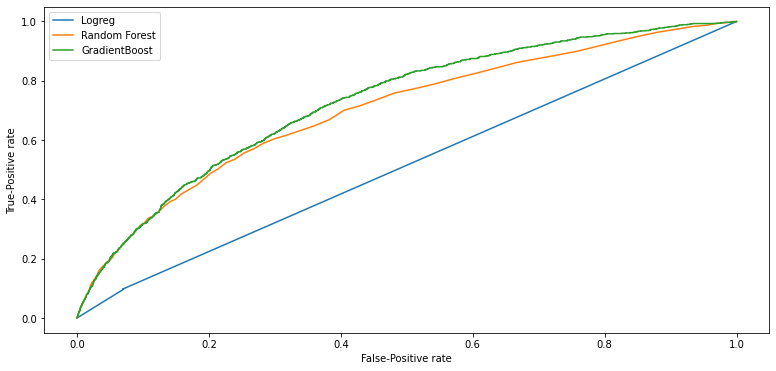

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots()
fig.set_size_inches(13,6)

for m in models_2:
    if x == 'Logreg':
        X_val_2 = scaler.transform(X_val)
    else:
        X_val_2=X_val
        
    y_pred = models_2[m].predict_proba(X_val_2)
    fpr, tpr, _ = roc_curve(y_val, y_pred[:,1].ravel())
    roc_auc = auc(fpr, tpr)
    print("%s Area under the ROC curve : %f" % (m, roc_auc))
    plt.plot(fpr,tpr, label=m)

plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.legend()
plt.show()


> **3.4. 스코어화**

In [ ]:
for model in models_2:
   model_pred = models_2[model].predict_proba(test_2)

In [ ]:
model_pred

array([[0.8912955 , 0.1087045 ],
       [0.83280618, 0.16719382],
       [0.97015348, 0.02984652],
       ...,
       [0.92869996, 0.07130004],
       [0.93805083, 0.06194917],
       [0.82200182, 0.17799818]])

In [ ]:
model.predict_proba(X_test)
# RF

array([[0.86333333, 0.13666667],
       [0.84666667, 0.15333333],
       [0.93666667, 0.06333333],
       ...,
       [0.85      , 0.15      ],
       [0.91666667, 0.08333333],
       [0.97      , 0.03      ]])

In [ ]:
model.predict_proba(X_test)
# gb

array([[0.95572754, 0.04427246],
       [0.93724002, 0.06275998],
       [0.76090112, 0.23909888],
       ...,
       [0.89791581, 0.10208419],
       [0.97400007, 0.02599993],
       [0.85765147, 0.14234853]])

In [ ]:
df_proba = pd.DataFrame(model.predict_proba(X_test))
df_proba 
# %%
df_proba['pred'] = model.predict(X_test)

In [ ]:
df_proba

In [ ]:
df_proba[0].plot.hist()

In [ ]:
df_importance = pd.DataFrame(train_1.columns.drop('TARGET') )
df_importance['importance'] = model.feature_importances_
df_importance.sort_values(by = 'importance', ascending=False).head(20)
# gb

,0,importance
0,EXT_SOURCE_3,0.305531
11,EXT_SOURCE_2,0.302201
57,DAYS_BIRTH,0.058643
12,AMT_GOODS_PRICE,0.034098
37,AMT_CREDIT,0.033367
70,CODE_GENDER_M,0.028629
13,AMT_ANNUITY,0.025249
94,NAME_EDUCATION_TYPE_Higher education,0.025192
56,DAYS_EMPLOYED,0.020891
54,DAYS_ID_PUBLISH,0.013283


In [ ]:
model.feature_importances_

array([3.05530538e-01, 0.00000000e+00, 3.10141993e-04, 1.89881620e-04,
       1.76627109e-03, 3.18372681e-03, 2.97852569e-03, 2.02439944e-03,
       2.36641370e-03, 6.86920358e-04, 4.59925137e-03, 3.02200691e-01,
       3.40981413e-02, 2.52488412e-02, 2.06534607e-03, 7.98700391e-03,
       1.13162383e-03, 0.00000000e+00, 5.53620074e-04, 1.10819628e-02,
       0.00000000e+00, 6.20657444e-07, 3.34526345e-04, 7.15378102e-05,
       5.17964233e-04, 4.57227978e-04, 0.00000000e+00, 3.88470526e-05,
       4.55641110e-04, 1.49532980e-04, 1.92065429e-04, 8.33769633e-04,
       1.49032785e-04, 9.53250277e-04, 3.27219470e-04, 0.00000000e+00,
       0.00000000e+00, 3.33673315e-02, 6.51475370e-03, 9.60045366e-04,
       2.99216038e-04, 2.50084075e-06, 6.03430011e-03, 3.49655454e-04,
       9.78099394e-05, 4.01077614e-04, 7.23592067e-03, 4.67193869e-03,
       7.62062541e-04, 6.97625652e-05, 1.76093227e-04, 1.57552595e-03,
       0.00000000e+00, 0.00000000e+00, 1.32832539e-02, 9.87145911e-03,
      

In [ ]:
import lightgbm as lgb
model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        

In [ ]:
 model.fit(X_train_2, y_train, eval_metric = 'auc',
                  eval_set = [(X_test_2, y_test), (X_train_2, y_train)],
                  eval_names = ['valid', 'train'], 
                  # categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 100 rounds.
[200]	train's binary_logloss: 0.546976	train's auc: 0.801296	valid's binary_logloss: 0.563407	valid's auc: 0.748922
Early stopping, best iteration is:
[167]	train's binary_logloss: 0.553801	train's auc: 0.794118	valid's binary_logloss: 0.567413	valid's auc: 0.749096


LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=1.0, importance_type='split',
               learning_rate=0.05, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=10000,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=50,
               reg_alpha=0.1, reg_lambda=0.1, silent=True, subsample=0.8,
               subsample_for_bin=200000, subsample_freq=0)

In [ ]:
  y_test_pred = model.predict(X_test_2)
  arg_test = {'y_true':y_test, 'y_pred':y_test_pred}
  print(confusion_matrix(**arg_test))
  print(classification_report(**arg_test))     

[[90402 36807]
 [ 3878  7293]]
              precision    recall  f1-score   support

           0       0.96      0.71      0.82    127209
           1       0.17      0.65      0.26     11171

    accuracy                           0.71    138380
   macro avg       0.56      0.68      0.54    138380
weighted avg       0.89      0.71      0.77    138380



In [ ]:
model.predict_proba(X_test)

array([[0.62062571, 0.37937429],
       [0.61907309, 0.38092691],
       [0.21571094, 0.78428906],
       ...,
       [0.34860163, 0.65139837],
       [0.74661073, 0.25338927],
       [0.30566632, 0.69433368]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18f728cd90>]],
      dtype=object)

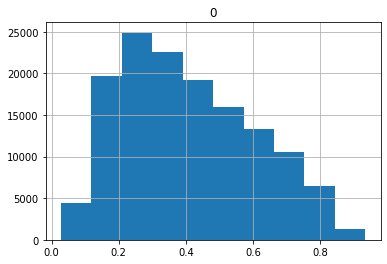

In [ ]:
pd.DataFrame(model.predict_proba(X_test)[:, 1]).hist()

GradientBoost Area under the ROC curve : 0.749096


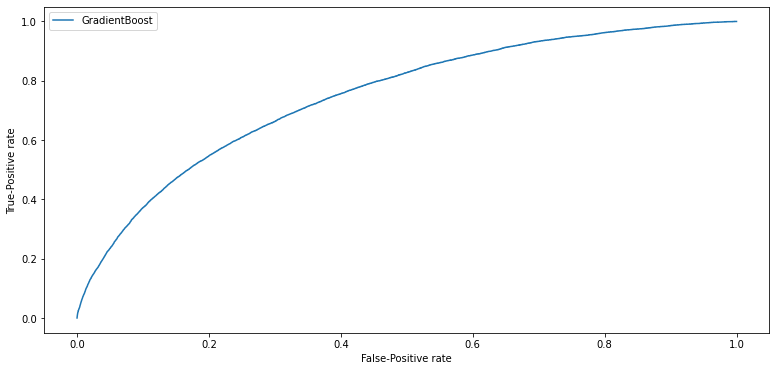

In [ ]:
# 6. ROC Curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fig, ax = plt.subplots()
fig.set_size_inches(13,6)

y_pred = model.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred[:,1].ravel())
roc_auc = auc(fpr, tpr)
print("%s Area under the ROC curve : %f" % (m, roc_auc))
plt.plot(fpr,tpr, label=m)

plt.xlabel('False-Positive rate')
plt.ylabel('True-Positive rate')
plt.legend()
plt.show()

In [ ]:
df_importance = pd.DataFrame(train_1.columns.drop('TARGET') )
df_importance['importance'] = model.feature_importances_
df_importance.sort_values(by = 'importance', ascending=False).head(20)
# gb

,0,importance
0,EXT_SOURCE_3,436
11,EXT_SOURCE_2,406
57,DAYS_BIRTH,379
37,AMT_CREDIT,348
13,AMT_ANNUITY,344
12,AMT_GOODS_PRICE,286
54,DAYS_ID_PUBLISH,273
56,DAYS_EMPLOYED,241
15,DAYS_LAST_PHONE_CHANGE,214
55,DAYS_REGISTRATION,169


In [ ]:
test_1_pred = model.predict_proba(test_1)

In [ ]:
test_1_pred

array([[0.65540015, 0.34459985],
       [0.31232572, 0.68767428],
       [0.85140947, 0.14859053],
       ...,
       [0.6089377 , 0.3910623 ],
       [0.55338763, 0.44661237],
       [0.3586585 , 0.6413415 ]])

In [ ]:
pd.DataFrame(test_1['SK_ID_CURR'])

,SK_ID_CURR
0,100001
1,100005
2,100013
3,100028
4,100038
...,...
48739,456221
48740,456222
48741,456223
48742,456224


In [ ]:
model.predict_proba(test_1)

array([[0.65540015, 0.34459985],
       [0.31232572, 0.68767428],
       [0.85140947, 0.14859053],
       ...,
       [0.6089377 , 0.3910623 ],
       [0.55338763, 0.44661237],
       [0.3586585 , 0.6413415 ]])

In [ ]:
df_proba = pd.DataFrame(test_1['SK_ID_CURR'])
df_proba['TARGET'] = model.predict_proba(test_1)[:, 1]

In [ ]:
df_proba

,SK_ID_CURR,TARGET
0,100001,0.344600
1,100005,0.687674
2,100013,0.148591
3,100028,0.300090
4,100038,0.815230
...,...,...
48739,456221,0.200258
48740,456222,0.704762
48741,456223,0.391062
48742,456224,0.446612


In [ ]:
df_proba.to_csv('df_proba_lgb.csv', index = False)
# 0.70895